# **Polynomial Equation**

## **Import the required libraries**

In [0]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

!pip install gensim
!pip install lightgbm

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  # stop words are, is, the etc. which are not needed for model
from nltk.stem.porter import PorterStemmer
from gensim.models import word2vec
from sklearn.manifold import TSNE

%matplotlib inline

from plotly import tools  # to install $ pip install plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.tree import DecisionTreeClassifier 
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb # to install $ pip install lightgbm
from PIL import Image

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Mount the shared drive on Google Colab**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Suppress Warnings**

In [0]:
# ignoring warnings to remove clutter 
import warnings
warnings.filterwarnings('ignore')

## **Load the data for base dataset and features for each team member**

**Load the features**

In [0]:
df_credibility_fact_checks = pd.read_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Snehal/Credibilty/Dataset/statement_score.csv")
df_controversy = pd.read_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/output_contro.csv")
df_context = pd.read_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Poorva/Context/enriched_data/train_contextfeature.csv")
df_sourceCredibility = pd.read_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Anand/source_credibility.csv")

**Load the Liar Liar dataset**

In [0]:
df = pd.read_csv("/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Snehal/Credibilty/Dataset/train.tsv", sep='\t', header = None)

#Adding the column names in test dataset
columns = ['id', 'label', 'statement', 'subjects', 'speaker',
         'speaker_job', 'state', 'party', 'barely_true_counts',
         'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
         'context']
df.columns = columns
df.head(5)

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


**Assign the 4 labels to a new column and add to the base dataset**

In [0]:
df['fake']=df['label']
df['fake']=np.where(df['label']=='half-true','true',df['fake'])
df['fake']=np.where(df['label']=='mostly-true','true',df['fake'])
df['fake']=np.where(df['label']=='barely-true','false',df['fake'])
df['fake']=np.where(df['label']=='pants-fire','false',df['fake'])

**Convert the categorical value of 'fake' column to numerical and assign the value to a new column 'fake_coded'**

In [0]:
df.fake = pd.Categorical(df.fake)
print(pd.Categorical(df.fake))
df['fake_coded'] = df.fake.cat.codes

[false, true, true, false, true, ..., true, true, true, false, false]
Length: 10240
Categories (2, object): [false, true]


**Print first few records after adding new columns 'fake' and 'fake_coded'**

In [0]:
df.head(5)

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,fake,fake_coded
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,true,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,true,1
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,false,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,true,1


**Importing entire notebooks is hard so we import the features via csv files and create dataframes out of them**

In [0]:
df['statement_feeling_score'] = df_credibility_fact_checks['statement_feeling_score']
df['controvery_score'] = df_controversy['label_id']
df['context_score'] = df_context['context_lda_topic_score']
df['source_score'] = df_sourceCredibility['source_doc2vec']
#Print the dataset after importing the features
df.head(5)

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,fake,fake_coded,statement_feeling_score,controvery_score,context_score,source_score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,0,-12,2.0,0.549999,0.054704
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,true,1,-12,1.0,0.699969,0.376065
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,true,1,-12,0.0,0.549988,0.527170
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,false,0,-11,3.0,0.699989,0.445341
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,true,1,-10,3.0,0.549983,0.060268


## **PairPlot to visualize the distribution of features in dataset**

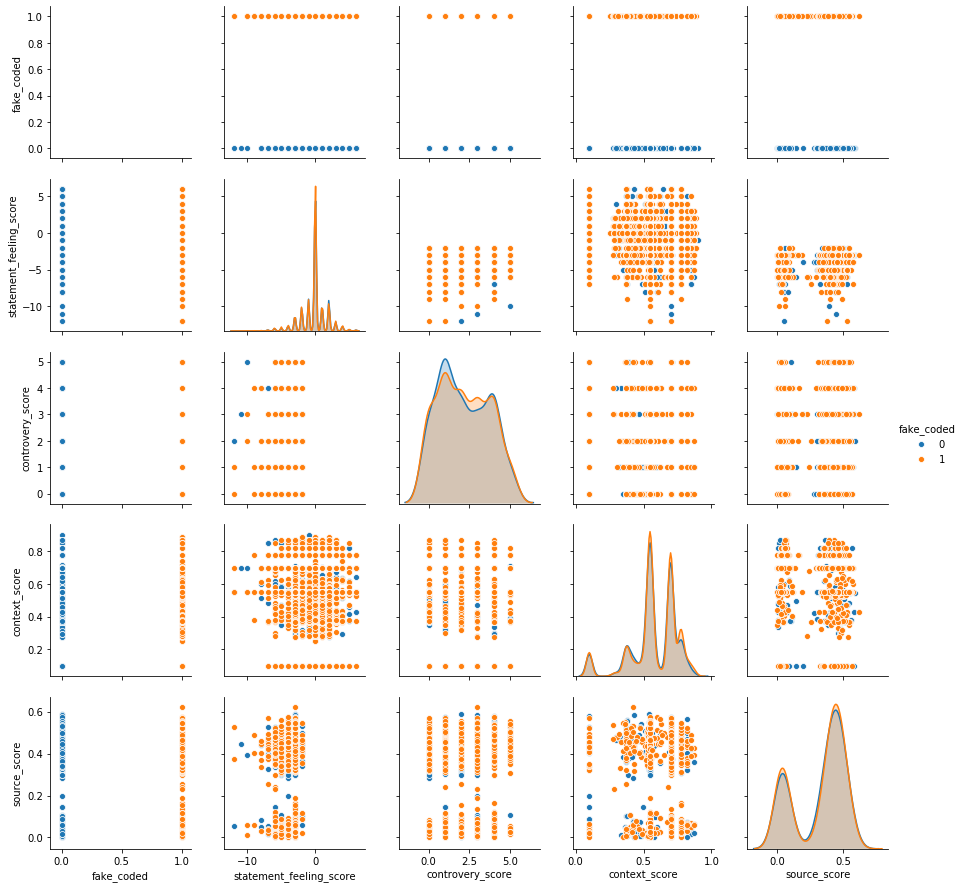

In [0]:
dk= df[['fake_coded','statement_feeling_score','controvery_score','context_score','source_score']]
dk.head()
sns.pairplot(data=dk, hue="fake_coded", dropna='true')

## **Encoding and Train Test splitting**

**Split the dataset into features and target**

In [0]:
# dropping columns which are not relevant or similar columns.
X = df[[ 'statement_feeling_score','controvery_score','context_score','source_score']]
y = df['fake_coded']
X = X.fillna(0);
y = y.fillna(0);

**Split the features and target into training and testing sets**

In [0]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)

## **Classification algorithms to determine feature importances (weight for polynomial equation)**

**Code to plot the ROC curve**

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return

**Code to get Precision and Recall score**

In [0]:
from sklearn.metrics import  average_precision_score, precision_recall_curve


# Function to get Precision recall curve
def get_prec_recall (y_test,y_pred):
    average_precision = average_precision_score(y_test, y_pred)
    print('Average precision-recall score : {}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='cyan')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    return

### **Logistic Regression**

**Train the Logistic Regression model**

In [0]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

**Predict on unseen data**

In [0]:
predictions = logmodel.predict(X_test)

**Get the feature importances**

In [0]:
#Getting feature importances 
print(logmodel.coef_)

[[-0.00418701 -0.01663877  0.3519812   0.18527437]]


**Print Confusion matrix**

In [0]:
#Validation
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[   0,  892],
       [   0, 1156]])

**Classification Report**

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       892
           1       0.56      1.00      0.72      1156

    accuracy                           0.56      2048
   macro avg       0.28      0.50      0.36      2048
weighted avg       0.32      0.56      0.41      2048



**K-Fold Cross validation**

In [0]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = logmodel, X = X_train, y = y_train, cv = 10)
accuracies.mean()

0.5610352436042698

**Plot the Confusion matrix**

Model Accuracy for Logistic Regression: 0.564453125


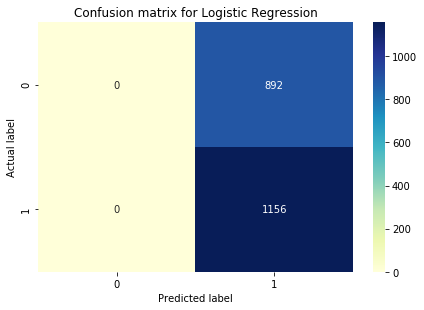

In [0]:
from sklearn.metrics import confusion_matrix
#print(confusion_matrix(y_test,predictions))
cnf_matrix_logreg = metrics.confusion_matrix(y_test, predictions)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_logreg), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Logistic Regression:",metrics.accuracy_score(y_test, predictions))

**Accuracy Score**

In [0]:
#from sklearn.metrics import accuracy_score 
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test,predictions)*100)

Accuracy :  56.4453125


**ROC Curve**

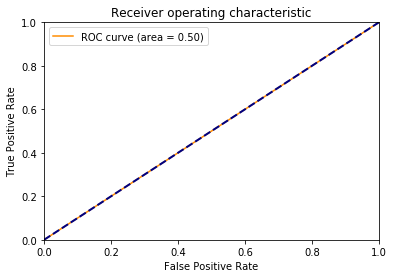

In [0]:
# Get ROC curve for Logistic Regression

get_roc(y_test,predictions)

### **Decision Tree**

**Train the Decision Tree model**

In [0]:
decclassifier = DecisionTreeClassifier()
decclassifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

**Predict on unseen data**

In [0]:
y_pred = decclassifier.predict(X_test)

**Plot the feature importances**

In [0]:
decclassifier.feature_importances_

array([0.14902466, 0.02670322, 0.73262993, 0.09164219])

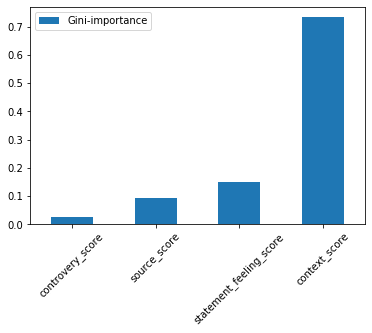

In [0]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, decclassifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

**Print Confusion matrix**

In [0]:
#Validation
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[347, 545],
       [369, 787]])

**Classification Report**

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.39      0.43       892
           1       0.59      0.68      0.63      1156

    accuracy                           0.55      2048
   macro avg       0.54      0.53      0.53      2048
weighted avg       0.54      0.55      0.55      2048



**K-Fold Cross validation**

In [0]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = decclassifier, X = X_train, y = y_train, cv = 10)
accuracies.mean()

0.5302671596398116

**Plot the Confusion matrix**

Model Accuracy for Decision tree: 0.5537109375


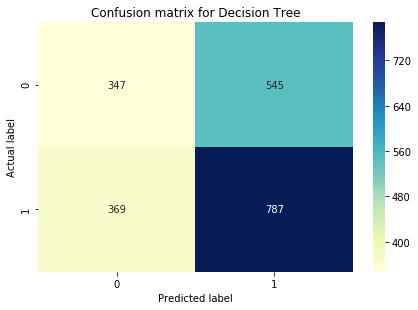

In [0]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
#print(confusion_matrix(y_test,predictions))
cnf_matrix_dectree = metrics.confusion_matrix(y_test, y_pred)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_dectree), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Decision Tree', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Decision tree:",metrics.accuracy_score(y_test, y_pred))

**Accuracy Score**

In [0]:
#from sklearn.metrics import accuracy_score 
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100)

Accuracy :  55.37109375


**ROC Curve**

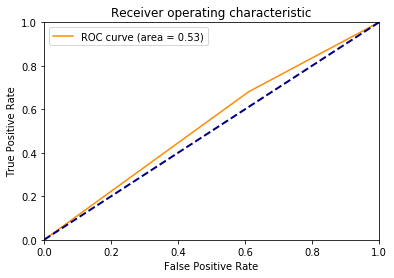

In [0]:
# Get ROC curve for Decision Tree

get_roc(y_test,y_pred)

### **Random Forest**

**Train the Random Forest model**

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Predict on unseen data**

In [0]:
rfc_pred = rfc.predict(X_test)

**Get the feature importances**

In [0]:
#'spam_score_fector','click_bait_score','toxicity_factor','src_url_polarity','sentiment_score','stance_factor_num'
rfc.feature_importances_

array([0.06590281, 0.02335563, 0.83558692, 0.07515463])

**Plot the feature importance and weight determination**

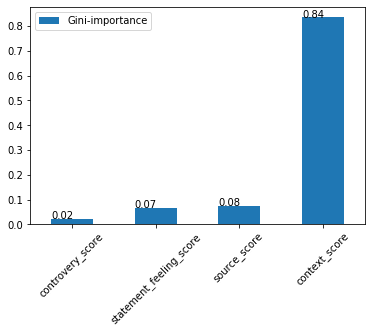

In [0]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
ax = importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),decimals=2)), (p.get_x(), p.get_height()))

**Print Confusion matrix**

In [0]:
print(confusion_matrix(y_test,rfc_pred))

[[310 582]
 [358 798]]


**Classification Report**

In [0]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.46      0.35      0.40       892
           1       0.58      0.69      0.63      1156

    accuracy                           0.54      2048
   macro avg       0.52      0.52      0.51      2048
weighted avg       0.53      0.54      0.53      2048



**Accuracy Score**

In [0]:
#from sklearn.metrics import accuracy_score 
print ("Accuracy : ", metrics.accuracy_score(y_test,rfc_pred)*100 )

Accuracy :  54.1015625


**Plot the Confusion matrix**

Model Accuracy for Random Forest: 55.37109375


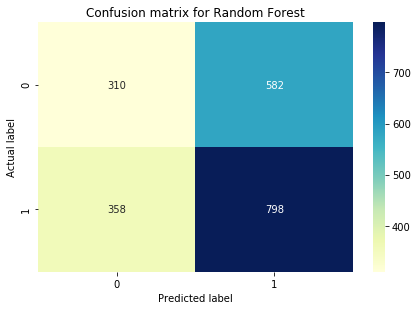

In [0]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
#print(confusion_matrix(y_test,predictions))
cnf_matrix_rf = metrics.confusion_matrix(y_test, rfc_pred)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_rf), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for Random Forest', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for Random Forest:",metrics.accuracy_score(y_test, y_pred)  * 100)

**ROC Curve**

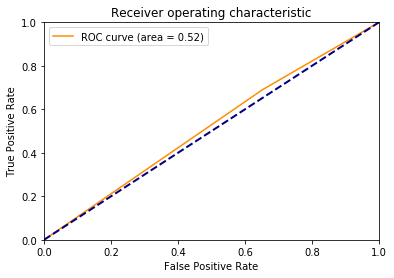

In [0]:
get_roc(y_test,rfc_pred)

**K-Fold Cross validation**

In [0]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10)
accuracies.mean()

0.5324652632834397

### **XGBoost**

**Train the XGBoost model**

In [0]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
xgclassifier = XGBClassifier()
xgclassifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**Predict on unseen data**

In [0]:
# Predicting the Test set results
xg_pred = xgclassifier.predict(X_test)

**Print Confusion matrix and Accuracy Score**

In [0]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, xg_pred)
print(cm)
print("Model Accuracy for XGBoost:",metrics.accuracy_score(y_test, xg_pred))

[[  52  840]
 [  62 1094]]
Model Accuracy for XGBoost: 0.5595703125


**Classification Report**

In [0]:
print(classification_report(y_test,xg_pred))

              precision    recall  f1-score   support

           0       0.46      0.06      0.10       892
           1       0.57      0.95      0.71      1156

    accuracy                           0.56      2048
   macro avg       0.51      0.50      0.41      2048
weighted avg       0.52      0.56      0.44      2048



**Plot the feature importance and weight determination**

In [0]:
feature_imp = xgclassifier.feature_importances_

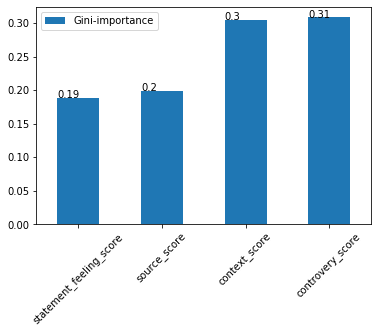

In [0]:
feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(X.columns, xgclassifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
ax = importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),decimals=2)), (p.get_x(), p.get_height()))

**Accuracy Score**

In [0]:
#from sklearn.metrics import accuracy_score 
print ("Accuracy : ", metrics.accuracy_score(y_test,xg_pred)*100)

Accuracy :  55.95703125


**Plot the Confusion matrix**

Model Accuracy for XGBoost: 55.95703125


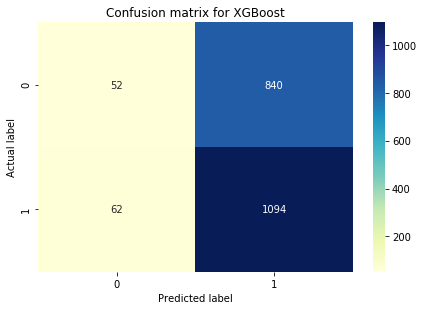

In [0]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, xg_pred)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for XGBoost', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for XGBoost:",metrics.accuracy_score(y_test, xg_pred) * 100)

**ROC Curve**

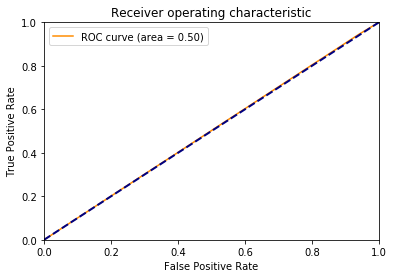

In [0]:
get_roc(y_test,xg_pred)

## **Calculate the Polynomial equation**

In [0]:
factors = ['Credibility Fact Checks', 'Controversy Score','Context', 'Source Credibility']

**Code block to calculate the Polynomial equation**

Since XGBoost has the highest accuracy, we will use XGBoost Gini-importance for weight determination of polynomial equation. The below code considers the feature importances (weight) calculated by XGBoost classifier and outputs the consolidated polynomial equation for all factors.

In [0]:
equation =  "Y = "
i = 0;
for x in feature_imp:            #Considering feature importances from XGBoost algorithm
  #equation = equation + " + (" + factors[i] + "*" + str(round(x, 2)) + ")"
  equation = equation + str(round(x, 2)) + "*" + "(" + factors[i] + ")" + " + "
  i = i + 1
  

i = 0
print(equation)
print("Feature Importances:")
for x in feature_imp:
  print(factors[i], ":", round(x, 2))
  i = i + 1

Y = 0.19*(Credibility Fact Checks) + 0.31*(Controversy Score) + 0.3*(Context) + 0.2*(Source Credibility) + 
Feature Importances:
Credibility Fact Checks : 0.19
Controversy Score : 0.31
Context : 0.3
Source Credibility : 0.2


Our hypothesis for polynomial equation can be visualized as above. Ideally, models internally construct equation and predict accordingly.

y = a1(Credibility Fact Checks) + a2(Controversy Score) + a3(Context) + a4(Source Credibility)
Our accuracies for the models are as follows. As XGBoost has the highest accuracy we will use XGBoost Gini-importance for weight.

Logistic Regression - 56.44%

Decision Tree - 56.29%

Random Forest - 56.34%

XGBoost - 56.49%

Thus, the Polynomial equation based on non-scalar factors is:

**0.19 * (Credibility Fact Checks) + 0.31 * (Controversy Score) + 0.30 * (Context) + 0.2 * (Source Credibility)**
